In [4]:
import pandas as pd
import numpy as np
from time import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.feature_extraction import text
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier


In [5]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/new-category-classification
data_set_file = "./Participants_Data_News_category/Data_Train.xlsx"
labels = {"Politics": 0,"Technology": 1, "Entertainment": 2, "Business": 3}
dataset = pd.read_excel(data_set_file)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/new-category-classification


Text(0.5, 1.0, 'Class Distribution')

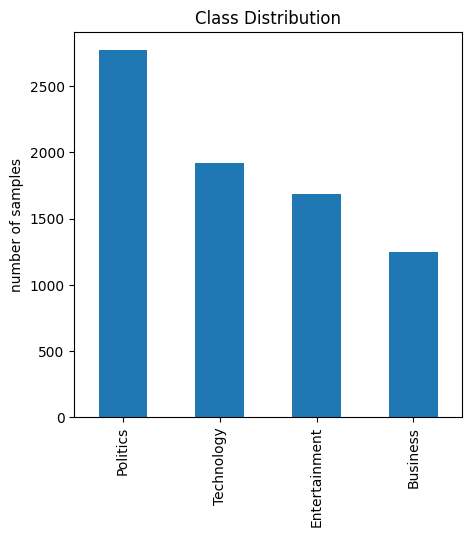

In [6]:
plt.figure(figsize=(5,5))
dataset['SECTION'].value_counts().plot(kind='bar')
plt.xticks([0,1,2,3],["Politics", "Technology", "Entertainment", "Business"])
plt.ylabel('number of samples')
plt.title("Class Distribution")

In [12]:
def to_vector(dataset):
    train, test = train_test_split(dataset, test_size=0.2)
    t0 = time()
    vectorizer = text.TfidfVectorizer(sublinear_tf=True, max_df=0.5, min_df=5, stop_words="english")
    X_train = vectorizer.fit_transform(train.STORY.tolist())
    y_train = np.array(train.SECTION.tolist())
    duration_train = time()-t0

    t0 = time()
    X_test = vectorizer.transform(test.STORY.tolist())
    y_test = np.array(test.SECTION.tolist())
    duration_test = time()-t0


    feature_name = vectorizer.get_feature_names_out()
    print(f"{len(dataset.SECTION)} documents ")
    print(f"vectorize training done in {duration_train:.3f}s")
    print(f"n_samples: {X_train.shape[0]}, n_features: {X_train.shape[1]}")

    print(f"vectorize testing done in {duration_test:.3f}s")
    print(f"n_samples: {X_test.shape[0]}, n_features: {X_test.shape[1]}")

    return X_train, y_train, X_test, y_test, feature_name, vectorizer
    

In [13]:
X_train, y_train, X_test, y_test, feature_name, vectorizer= to_vector(dataset)

7628 documents 
vectorize training done in 0.636s
n_samples: 6102, n_features: 8444
vectorize testing done in 0.145s
n_samples: 1526, n_features: 8444


accuracy_score :-  0.9711664482306684
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       326
           1       0.97      0.98      0.97       565
           2       0.96      0.98      0.97       370
           3       0.99      0.95      0.97       265

    accuracy                           0.97      1526
   macro avg       0.97      0.97      0.97      1526
weighted avg       0.97      0.97      0.97      1526




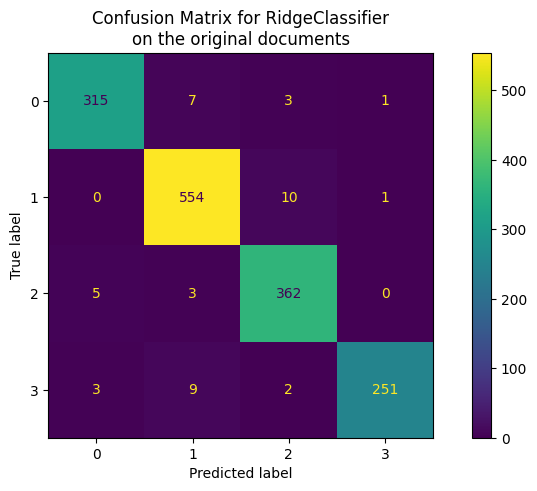

In [14]:
clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print("accuracy_score :- ", accuracy_score(y_test, pred))
fig, ax = plt.subplots(figsize=(10,5))
_ = ax.set_title(f"Confusion Matrix for {clf.__class__.__name__}\non the original documents")
ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=ax)
print(f"{classification_report(y_test,pred,zero_division=0)}\n")


In [15]:
test = pd.read_excel('./Participants_Data_News_category/Data_Test.xlsx')
sentence = test['STORY'].tolist()
X = vectorizer.transform(test.STORY.tolist())
prediction = clf.predict(X)
print('-'*10)
print(prediction)
df_out = pd.DataFrame(prediction, columns=['SECTION'])
df_out.to_csv('./submission_RidgeClassifier.csv')

----------
[1 2 1 ... 1 0 1]


In [ ]:
from sklearn.utils.extmath import density
from sklearn import metrics
def benchmark_models(clf, custom_name=False):
    print("_"*80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time()-t0
    print(f"Training time :{train_time:.3}s")

    t0 = time()
    pred =  clf.predict(X_test)
    test_time = time()-t0
    print(f"Testing time :{test_time:.3}s")

    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=pred)
    f1_score = metrics.f1_score(y_true=y_test, y_pred=pred, average='micro')
    print(f"accuracy: {accuracy:.3}")
    print(f"f1 score: {f1_score:.3}")
    
    if hasattr(clf, "coef_"):
        print(f"dimensionality: {clf.coef_.shape[1]}")
        print(f"density: {density(clf.coef_)}")
        print()
    
    clf_descr = clf.__class__.__name__

    return clf_descr, accuracy, train_time, test_time

In [ ]:

result = []
for clf, name in (
    (LogisticRegression(C=5, max_iter=1000), "Logistic Regression"),
    (RidgeClassifier(alpha=1.0, solver="sparse_cg"),"Ridge Classifier"), 
    (KNeighborsClassifier(n_neighbors=100),"KNN"),
    (RandomForestClassifier(),"Random Forset"),
    (LinearSVC(C=1.0, dual=False, max_iter=1000), "Linear SVC"),
    (SGDClassifier(loss="hinge", alpha=1e-4, n_iter_no_change=3, early_stopping=True), "SDGclassifier with log loss"),
    (NearestCentroid(), "NearestCentroid"),
    (ComplementNB(alpha=1.0), "Complement naive Bayes"),
    (DecisionTreeClassifier(), "Decision Tree Classifier ")
    ):
    print("="*80)
    print(name)
    result.append(benchmark_models(clf,name))

Logistic Regression
________________________________________________________________________________
Training: 
LogisticRegression(C=5, max_iter=1000)
Training time :0.578s
Testing time :0.000698s
accuracy: 0.972
f1 score: 0.972
dimensionality: 8433
density: 1.0

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(solver='sparse_cg')
Training time :0.0401s
Testing time :0.000487s
accuracy: 0.974
f1 score: 0.974
dimensionality: 8433
density: 1.0

KNN
________________________________________________________________________________
Training: 
KNeighborsClassifier(n_neighbors=100)
Training time :0.000909s
Testing time :0.25s
accuracy: 0.955
f1 score: 0.955
Random Forset
________________________________________________________________________________
Training: 
RandomForestClassifier()
Training time :1.05s
Testing time :0.0357s
accuracy: 0.949
f1 score: 0.949
Linear SVC
_________________________________________________

/Users/suyog/miniforge3/envs/pyt_m1/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


Training time :0.411s
Testing time :0.000612s
accuracy: 0.855
f1 score: 0.855
